# **DATA PREPROCESSING**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [4]:
df= pd.read_csv("/content/drive/MyDrive/SY/DM/DATASETS/loan_data.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         562 non-null    int64  
 1   Loan_ID            562 non-null    object 
 2   Gender             553 non-null    object 
 3   Married            562 non-null    object 
 4   Dependents         549 non-null    object 
 5   Education          551 non-null    object 
 6   Self_Employed      532 non-null    object 
 7   ApplicantIncome    540 non-null    float64
 8   CoapplicantIncome  530 non-null    float64
 9   LoanAmount         550 non-null    float64
 10  Loan_Amount_Term   547 non-null    float64
 11  Credit_History     516 non-null    float64
 12  Property_Area      562 non-null    object 
 13  Loan_Status        562 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 61.6+ KB


## **DATA CLEANING**

In [6]:
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001001,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
1,1,LP001002,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
2,2,LP001003,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
3,3,LP001004,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y
4,4,LP001005,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.0,360.0,1.0,Urban,Y


*Step 1: Reconsider Feature Selection*

In [7]:
df = df.drop(columns=['Unnamed: 0', 'Loan_ID', 'Gender'])

*Step 2: Handle Missing Values*

In [8]:
df.isna().sum()

,0
Married,0
Dependents,13
Education,11
Self_Employed,30
ApplicantIncome,22
CoapplicantIncome,32
LoanAmount,12
Loan_Amount_Term,15
Credit_History,46
Property_Area,0


In [9]:
df.isna().sum().sum()

np.int64(181)

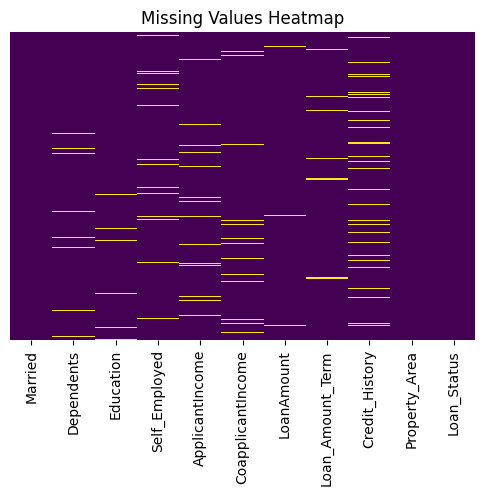

In [10]:
# Missing Values Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [11]:
# Using Median
df['ApplicantIncome'] = df['ApplicantIncome'].fillna(df['ApplicantIncome'].median())
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())

# Using Mode
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])

# Convert '3+' in 'Dependents' to numeric 3 (New Change)
df['Dependents'] = df['Dependents'].replace({'3+': 3}).astype(float)

# Fill missing values with 0
df['CoapplicantIncome'] = df['CoapplicantIncome'].fillna(0)

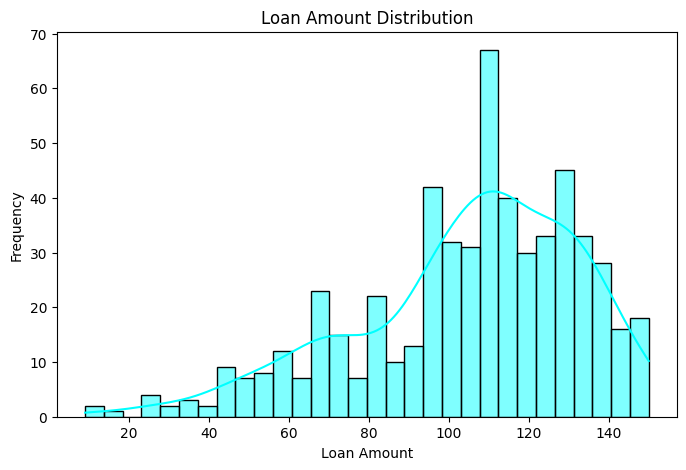

In [12]:
# Understand the spread of loan amounts
plt.figure(figsize=(8, 5))
sns.histplot(df["LoanAmount"], bins=30, kde=True, color='cyan')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()

In [13]:
# Use KNN Imputer for more complex missing value handling
imputer = KNNImputer(n_neighbors=5)
numeric_cols = ['ApplicantIncome', 'LoanAmount', 'Credit_History']
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

imputer = KNNImputer(n_neighbors=5)
df[['Loan_Amount_Term']] = imputer.fit_transform(df[['Loan_Amount_Term']])

*Step 3: Encoding Categorical Variables*

In [14]:
categorical_cols = ['Education', 'Self_Employed', 'Married', 'Property_Area']
ohe = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(ohe.fit_transform(df[categorical_cols]), columns=ohe.get_feature_names_out())
df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_cats], axis=1)

In [15]:
df = df.drop(columns=[col for col in df.columns if 'nan' in col])

In [16]:
scaler = StandardScaler()
scaled_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# **CLASSIFICATION**

*Importing Necessary things from the Python Libraries*

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [18]:
# Encode Target Variable
label_encoder = LabelEncoder()
df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])  # Convert 'Y'/'N' to 1/0

# Split data into X (features) and y (target)
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

print(f"X shape: {X.shape}, y shape: {y.shape}")
print("Missing values:\n", X.isnull().sum())

X shape: (562, 11), y shape: (562,)
Missing values:
 Dependents                 0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Education_Not Graduate     0
Self_Employed_Yes          0
Married_Yes                0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64


In [19]:
# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X, y)

# Get feature importances
importances = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

Credit_History             0.330601
ApplicantIncome            0.186231
LoanAmount                 0.169280
CoapplicantIncome          0.108922
Loan_Amount_Term           0.050854
Dependents                 0.040841
Property_Area_Semiurban    0.027992
Married_Yes                0.023068
Education_Not Graduate     0.022446
Property_Area_Urban        0.022150
Self_Employed_Yes          0.017616
dtype: float64


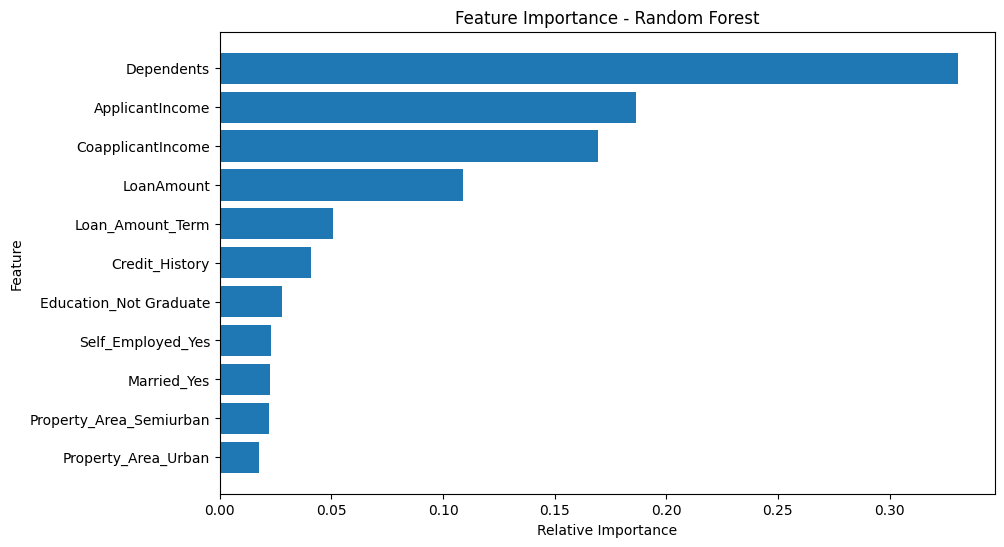

In [20]:
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances.iloc[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.show()

In [21]:
low_importance_features = ['Self_Employed_Yes', 'Property_Area_Urban',
                           'Education_Not Graduate', 'Married_Yes', 'Property_Area_Semiurban']
X = X.drop(columns=low_importance_features)

In [22]:
# Spliting the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model again
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Evaluating new accuracy
new_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after feature removal: {new_accuracy:.4f}")

Accuracy after feature removal: 0.9115


In [23]:
train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data.drop(columns=["Loan_Status"])
y_train = train_data["Loan_Status"]

print(X_train.shape, y_train.shape)

(449, 6) (449,)


## **1. Decision Tree Classification**

*With no parameters*

In [24]:
dftree1= DecisionTreeClassifier()
dftree1.fit(X_train, y_train)

# Prediction
y_pred1= dftree1.predict(X_test)

# Accuracy Check
acc1= accuracy_score(y_test, y_pred1)
print("Decision Tree Accuracy:", acc1)

Decision Tree Accuracy: 0.8407079646017699


In [25]:
# Confusion Matrix
con_mat_dt1 = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(con_mat_dt1)

Confusion Matrix:
[[23  7]
 [11 72]]


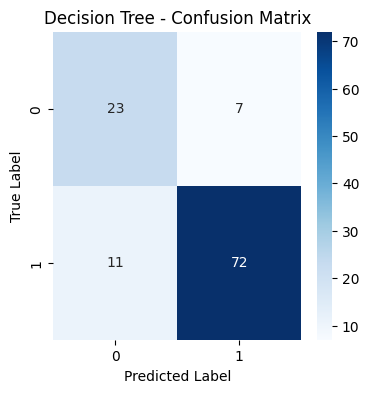

In [26]:
# Ploting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_dt1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree - Confusion Matrix')
plt.show()

In [27]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        30
           1       0.91      0.87      0.89        83

    accuracy                           0.84       113
   macro avg       0.79      0.82      0.80       113
weighted avg       0.85      0.84      0.84       113



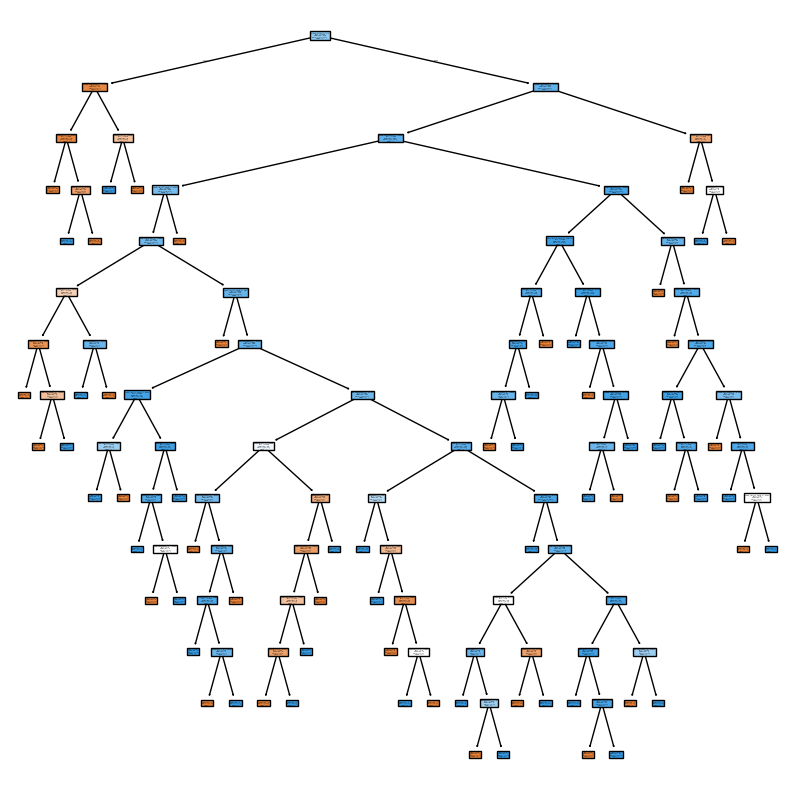

In [28]:
#Decision Tree figure 1
plt.figure(figsize=(10,10))
plot_tree(dftree1, feature_names=X.columns, class_names=[str(cls) for cls in dftree1.classes_], filled=True)
plt.show()

*With parameters*

In [29]:
dftree2= DecisionTreeClassifier(criterion='gini', max_depth=5,min_samples_split=2, min_samples_leaf=1, max_features=None, class_weight=None, random_state=42)
dftree2.fit(X_train,y_train)

# Prediction
Ypred1_2= dftree2.predict(X_test)

# Accuracy Check
acc2= accuracy_score(y_test, Ypred1_2)
print("Decision Tree Accuracy:", acc2)

Decision Tree Accuracy: 0.8141592920353983


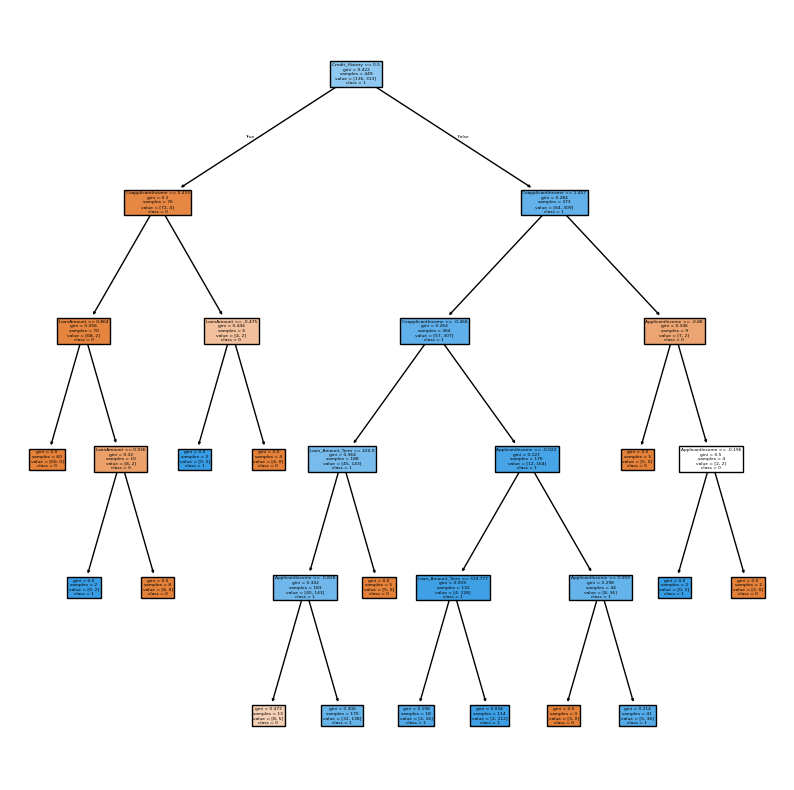

In [30]:
#Decision Tree Figure 2
plt.figure(figsize=(10,10))
plot_tree(dftree2, feature_names= X.columns, class_names=[str(cls) for cls in dftree2.classes_], filled=True)
plt.show()

In [31]:
dftree3= DecisionTreeClassifier(criterion='entropy', max_depth=10,min_samples_split=2, min_samples_leaf=1, max_features=None, class_weight=None, random_state=42)
dftree3.fit(X_train, y_train)

# Prediction
Ypred1_3= dftree3.predict(X_test)

# Accuracy Check
acc3= accuracy_score(y_test, Ypred1_3)
print("Decision Tree Accuracy:", acc3)

Decision Tree Accuracy: 0.8849557522123894


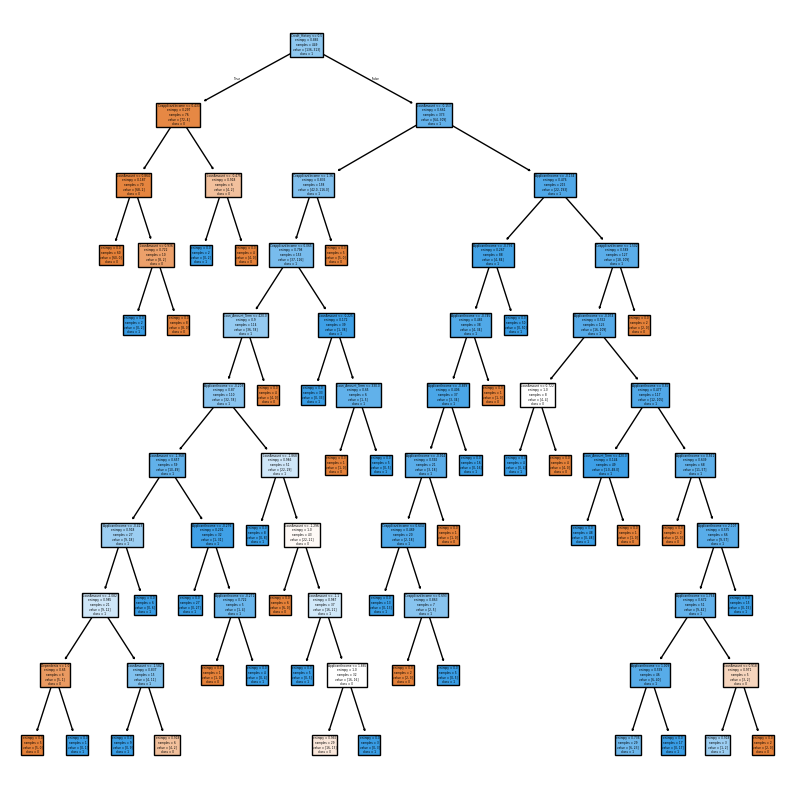

In [32]:
# Decision Tree Figure 3
plt.figure(figsize=(10,10))
plot_tree(dftree3, feature_names=X.columns, class_names=[str(cls) for cls in dftree3.classes_], filled=True)
plt.show()

In [33]:
print('After changing the parameter we get slighly different accuracy%')
print('------------------------------------------------------------------')
print('O Without any parameters= ', format(acc1,'.2f'))
print('')
print('O With parameters(gini, max_depth, etc.)= ', format(acc2,'.2f'))
print('')
print('O With parameters(entropy, max_depth, etc.)= ', format(acc3,'.2f'))

After changing the parameter we get slighly different accuracy%
------------------------------------------------------------------
O Without any parameters=  0.84

O With parameters(gini, max_depth, etc.)=  0.81

O With parameters(entropy, max_depth, etc.)=  0.88


In [34]:
dt_params = {'criterion':['gini', 'entropy', 'log_loss'],'splitter':['best', 'random'], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
print("Best Decision Tree Params:", dt_grid.best_params_)

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'splitter': 'best'}


In [35]:
dftree = dt_grid.best_estimator_
y_pred_dt = dftree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8672566371681416


## **2. Gaussian Naive Bayes Classification**

In [36]:
gnb1 = GaussianNB()
gnb1.fit(X_train, y_train)

# Prediction
y_pred1 = gnb1.predict(X_test)

# Accuracy Check
acc2_1= accuracy_score(y_test, y_pred1)
print("GNB Accuracy:", acc2_1)

GNB Accuracy: 0.8407079646017699


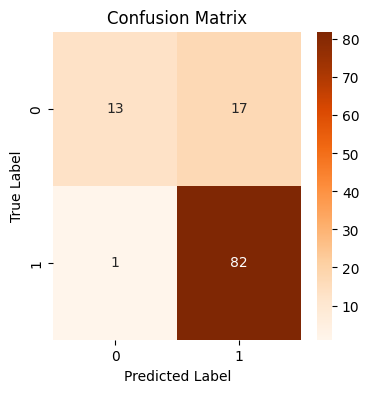

In [37]:
# Plotting Confusion Matrix
con_mat=confusion_matrix(y_test,y_pred1)
con_mat=confusion_matrix(y_test,y_pred1)
plt.figure(figsize=(4, 4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.43      0.59        30
           1       0.83      0.99      0.90        83

    accuracy                           0.84       113
   macro avg       0.88      0.71      0.75       113
weighted avg       0.85      0.84      0.82       113



**Gaussian NB with parameters**

In [39]:
priors= (0.2,0.8)
gnb2=GaussianNB(priors= priors, var_smoothing= 1e-9)

gnb2.fit(X_train,y_train)

# Prediction
y_pred2=gnb2.predict(X_test)

#Accuracy Check
acc2_2=metrics.accuracy_score(y_test,y_pred2)
print("GNB Accuracy:", acc2_2)

GNB Accuracy: 0.8407079646017699


In [40]:
print('After changing the parameter we get slighly different accuracy%')
print('------------------------------------------------------------------')
print('O Without any parameters= ', format(acc2_1))
print('')
print('O With parameters(priors, var_smoothing)= ', format(acc2_2))

After changing the parameter we get slighly different accuracy%
------------------------------------------------------------------
O Without any parameters=  0.8407079646017699

O With parameters(priors, var_smoothing)=  0.8407079646017699


In [41]:
nb_params = {'var_smoothing': np.logspace(-9, 0, 10)}
nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='accuracy')
nb_grid.fit(X_train, y_train)
print("Best Naïve Bayes Params:", nb_grid.best_params_)

Best Naïve Bayes Params: {'var_smoothing': np.float64(1e-09)}


In [42]:
gnb = nb_grid.best_estimator_
y_pred_nb = gnb.predict(X_test)
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naïve Bayes Accuracy: 0.8407079646017699


## **3. S V Classification**

In [43]:
sk1= SVC(C=1.0, kernel='linear', gamma='scale', random_state=42, class_weight=None)
sk1.fit(X_train, y_train)

# Prediction
Ypred3_1= sk1.predict(X_test)

# Accuracy Check
acc3_1= accuracy_score(y_test, Ypred3_1)
print("SVC Accuracy:",acc3_1)

SVC Accuracy: 0.8407079646017699


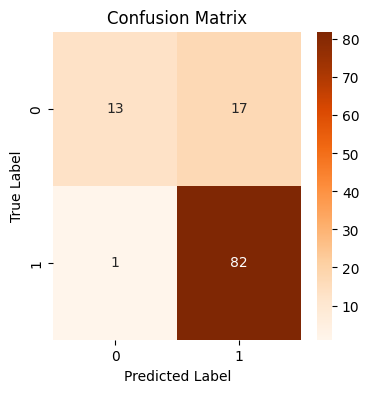

In [44]:
# Plotting Confusion Matrix
con_mat2=confusion_matrix(y_test, Ypred3_1)
plt.figure(figsize=(4,4))
sns.heatmap(con_mat2, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print(classification_report(y_test, Ypred3_1))

              precision    recall  f1-score   support

           0       0.93      0.43      0.59        30
           1       0.83      0.99      0.90        83

    accuracy                           0.84       113
   macro avg       0.88      0.71      0.75       113
weighted avg       0.85      0.84      0.82       113



In [46]:
sk2= SVC(C=10.0, kernel='poly', gamma='scale', random_state=42, class_weight=None)
sk2.fit(X_train, y_train)

# Prediction
Ypred3_2= sk2.predict(X_test)

# Accuracy Check
acc3_2= accuracy_score(y_test, Ypred3_2)
print("SVC Accuracy:",acc3_2)

SVC Accuracy: 0.7345132743362832


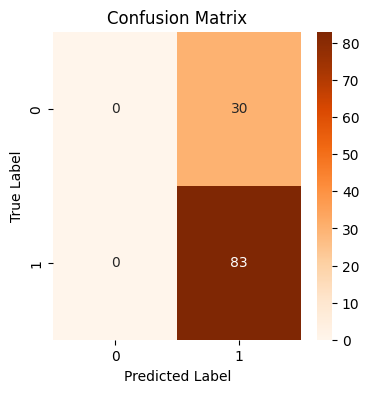

In [47]:
# Plotting Confusion Matrix
con_mat3=confusion_matrix(y_test, Ypred3_2)
plt.figure(figsize=(4,4))
sns.heatmap(con_mat3, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [48]:
sk3= SVC(C=100.0, kernel='rbf', gamma='scale', random_state=42, class_weight=None)
sk3.fit(X_train, y_train)

# Prediction
Ypred3_3= sk3.predict(X_test)

# Accuracy Check
acc3_3= accuracy_score(y_test, Ypred3_3)
print("SVC Accuracy:",acc3_3)

SVC Accuracy: 0.7256637168141593


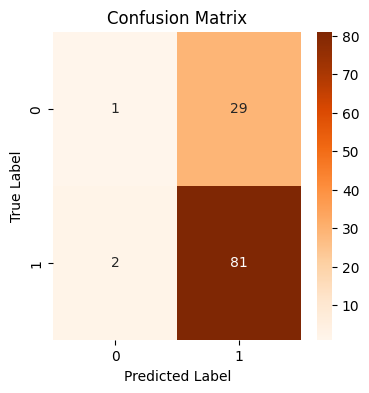

In [49]:
# Plotting Confusion Matrix
con_mat3=confusion_matrix(y_test, Ypred3_3)
plt.figure(figsize=(4,4))
sns.heatmap(con_mat3, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
print('After changing the parameter we get slighly different accuracy%')
print('------------------------------------------------------------------')
print('O With parameters(kernal= linear, etc.)= ', format(acc3_1,'.2f'))
print('')
print('O With parameters(kernal=polynomial, etc.)= ', format(acc3_2,'.2f'))
print('')
print('O With parameters(kernal=rbf, etc.)= ', format(acc3_3,'.2f'))

After changing the parameter we get slighly different accuracy%
------------------------------------------------------------------
O With parameters(kernal= linear, etc.)=  0.84

O With parameters(kernal=polynomial, etc.)=  0.73

O With parameters(kernal=rbf, etc.)=  0.73


In [51]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
print("Best SVM Params:", svm_grid.best_params_)

Best SVM Params: {'C': 0.1, 'kernel': 'linear'}


In [52]:
svm_model = svm_grid.best_estimator_
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.8407079646017699


### MODEL COMPARISION

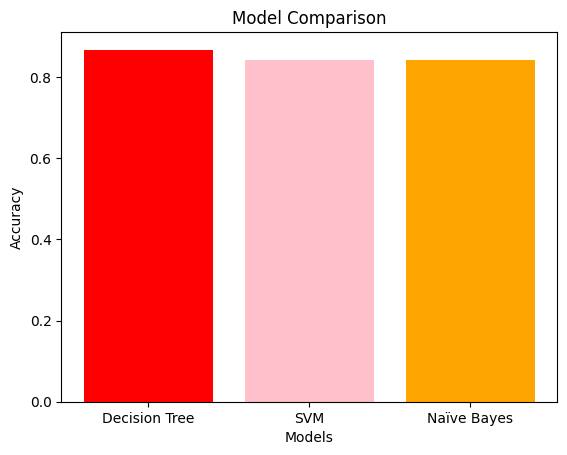

In [53]:
# Model Comparison
models = ['Decision Tree', 'SVM', 'Naïve Bayes']
accuracies = [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_nb)]
plt.bar(models, accuracies, color=['red', 'pink', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# **DATA VISUALIZATION**

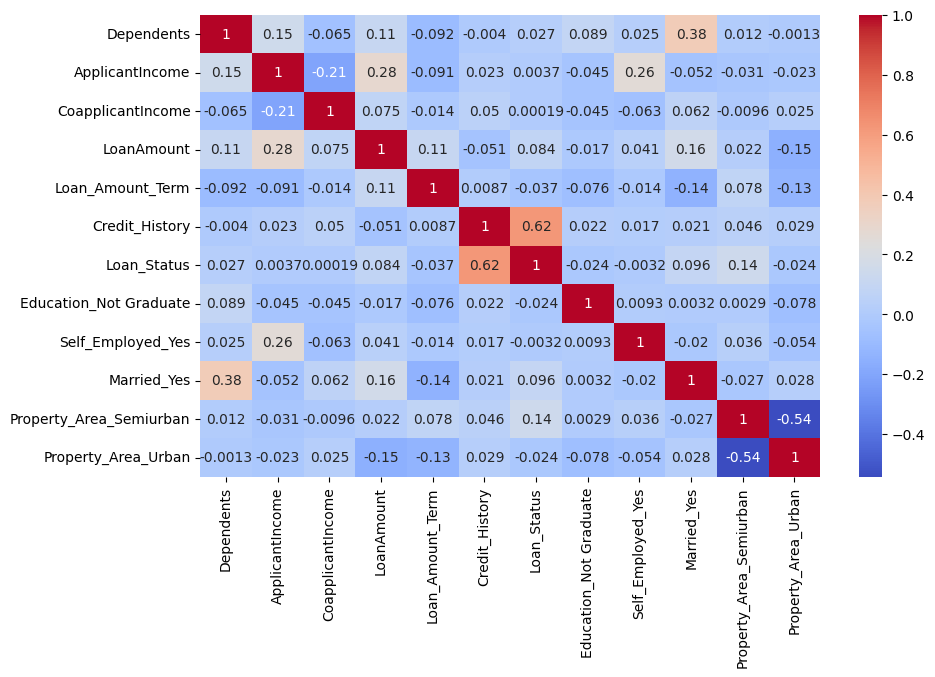

In [54]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

Text(0, 0.5, 'Frequency')

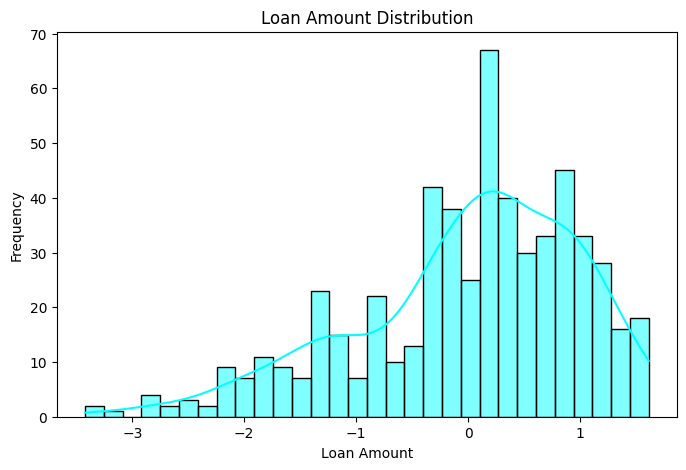

In [60]:
# Helps understand the spread of loan amounts
plt.figure(figsize=(8, 5))
sns.histplot(df["LoanAmount"], bins=30, kde=True, color='cyan')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")

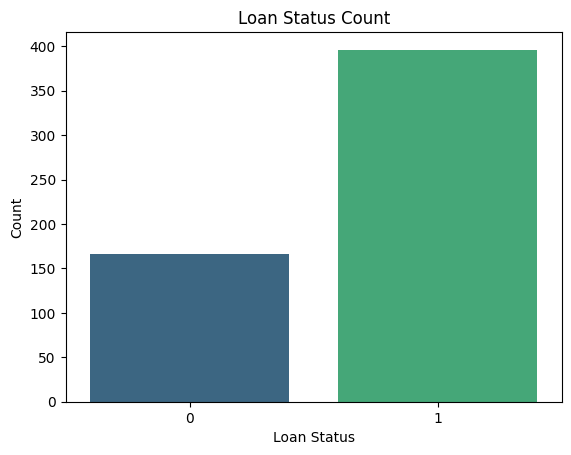

In [56]:
# Check class distribution (Loan Approved vs Rejected)
sns.countplot(data=df, x="Loan_Status", hue="Loan_Status", palette="viridis", legend=False)
plt.title("Loan Status Count")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

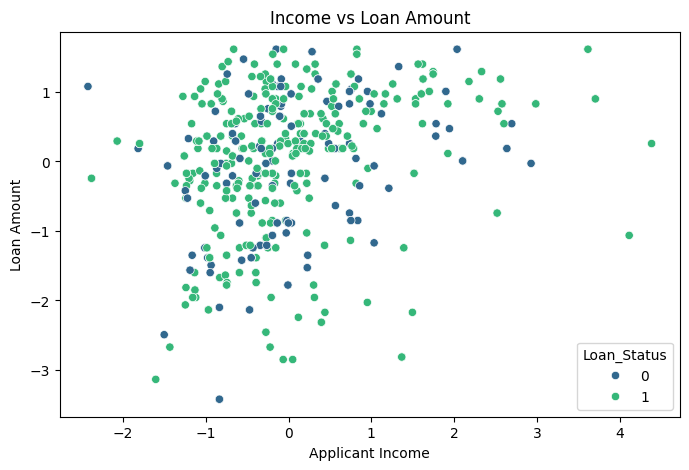

In [57]:
# Shows the relationship between income and loan amount
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["ApplicantIncome"], y=df["LoanAmount"], hue=df["Loan_Status"], palette='viridis')
plt.title("Income vs Loan Amount")
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")
plt.show()

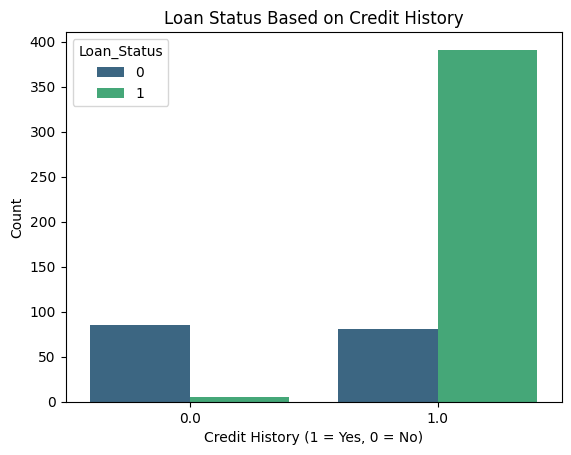

In [58]:
# Shows how credit history influences loan approval
sns.countplot(data=df, x="Credit_History", hue="Loan_Status", palette="viridis")
plt.title("Loan Status Based on Credit History")
plt.xlabel("Credit History (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

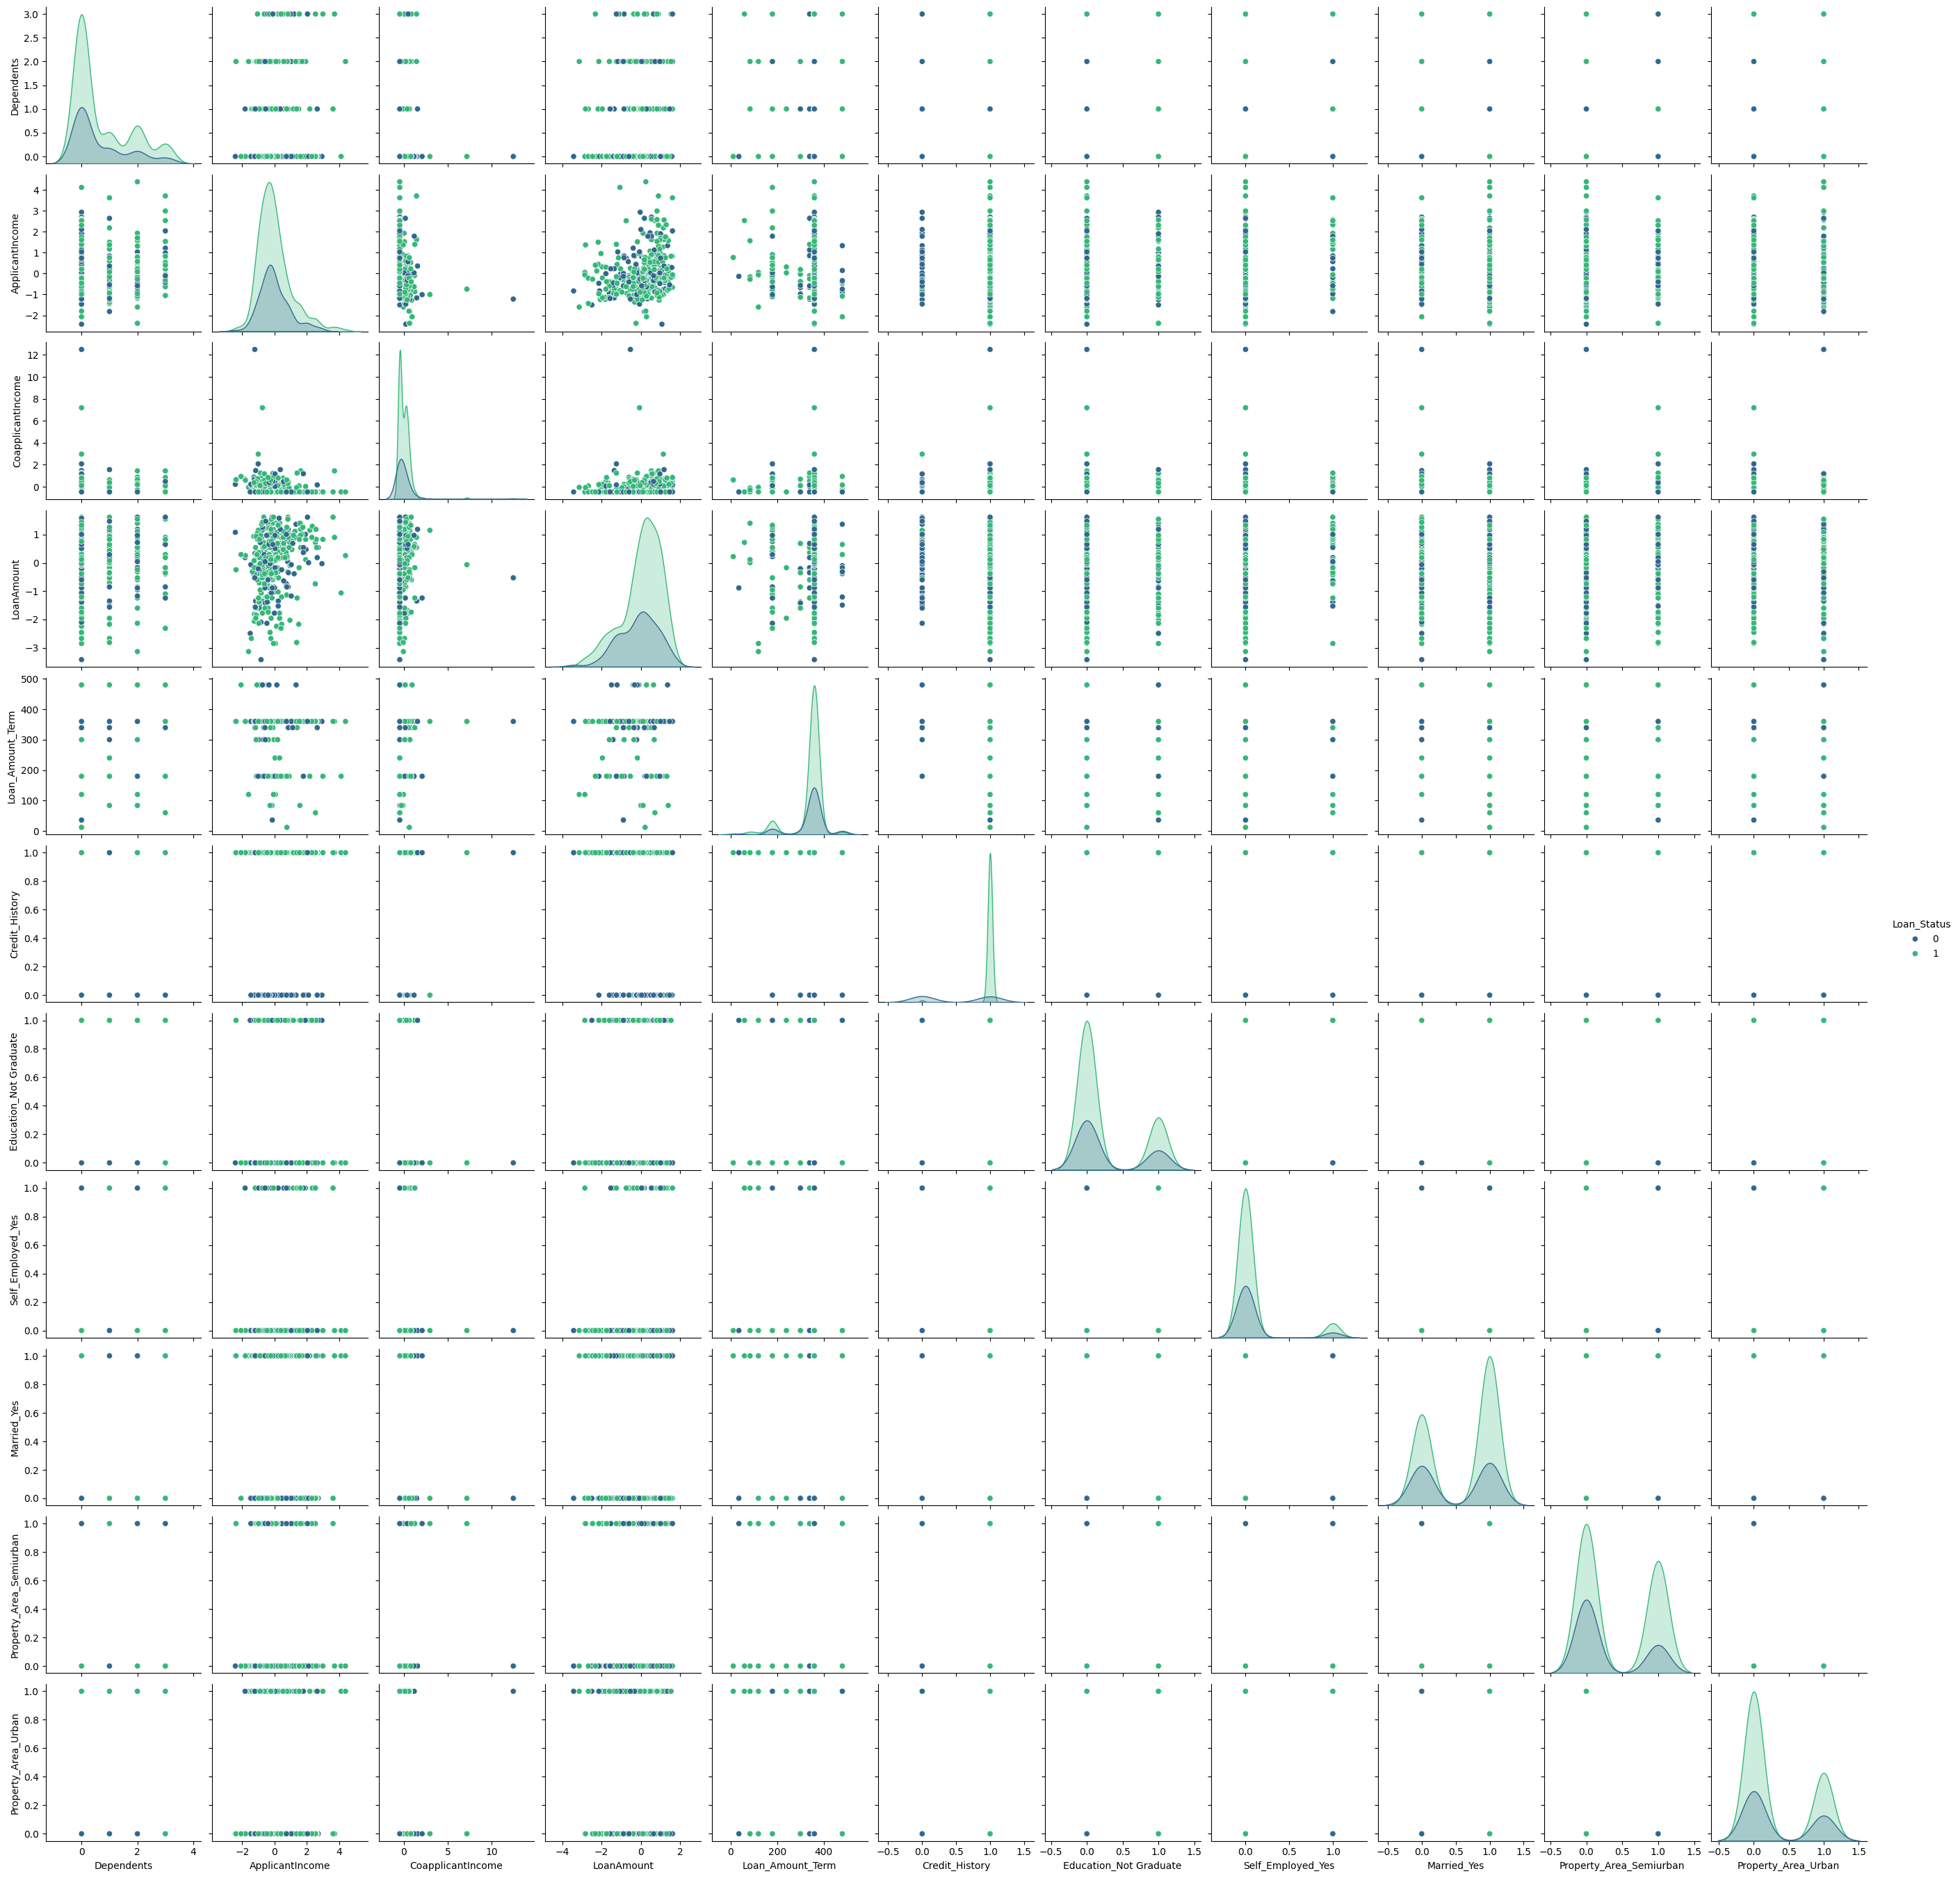

In [61]:
# Shows pairwise relationships
sns.pairplot(df, hue="Loan_Status", diag_kind="kde", palette="viridis")
plt.show()